In [1]:
# Perform operations on data frames
import pandas as pd              
#Perform numeric operations on data
import numpy as np               
#For static visualizations
import matplotlib.pyplot as plt  
%matplotlib inline 
#For advanced visualizations
import seaborn as sns
import random
import warnings
from tqdm import tqdm
from zipfile import ZipFile
import pickle
import json
import gc

# Helps to extract the data using regular expressions
import re

# Helps to remove the punctuation
import string,unicodedata

# It helps to remove the accented characters 
import unidecode

#It helps in fixing word contractions
import contractions

# It help to correct the spelling
from autocorrect import Speller
from ftlangdetect import detect

#Import html parser
from bs4 import BeautifulSoup

# Importing the NLTK library
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
lemmatizer = WordNetLemmatizer()

#Import word2vec
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Import sklearn related packages
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer         


# Import tensorflow related packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, InputLayer, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
from tensorflow.keras import backend
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

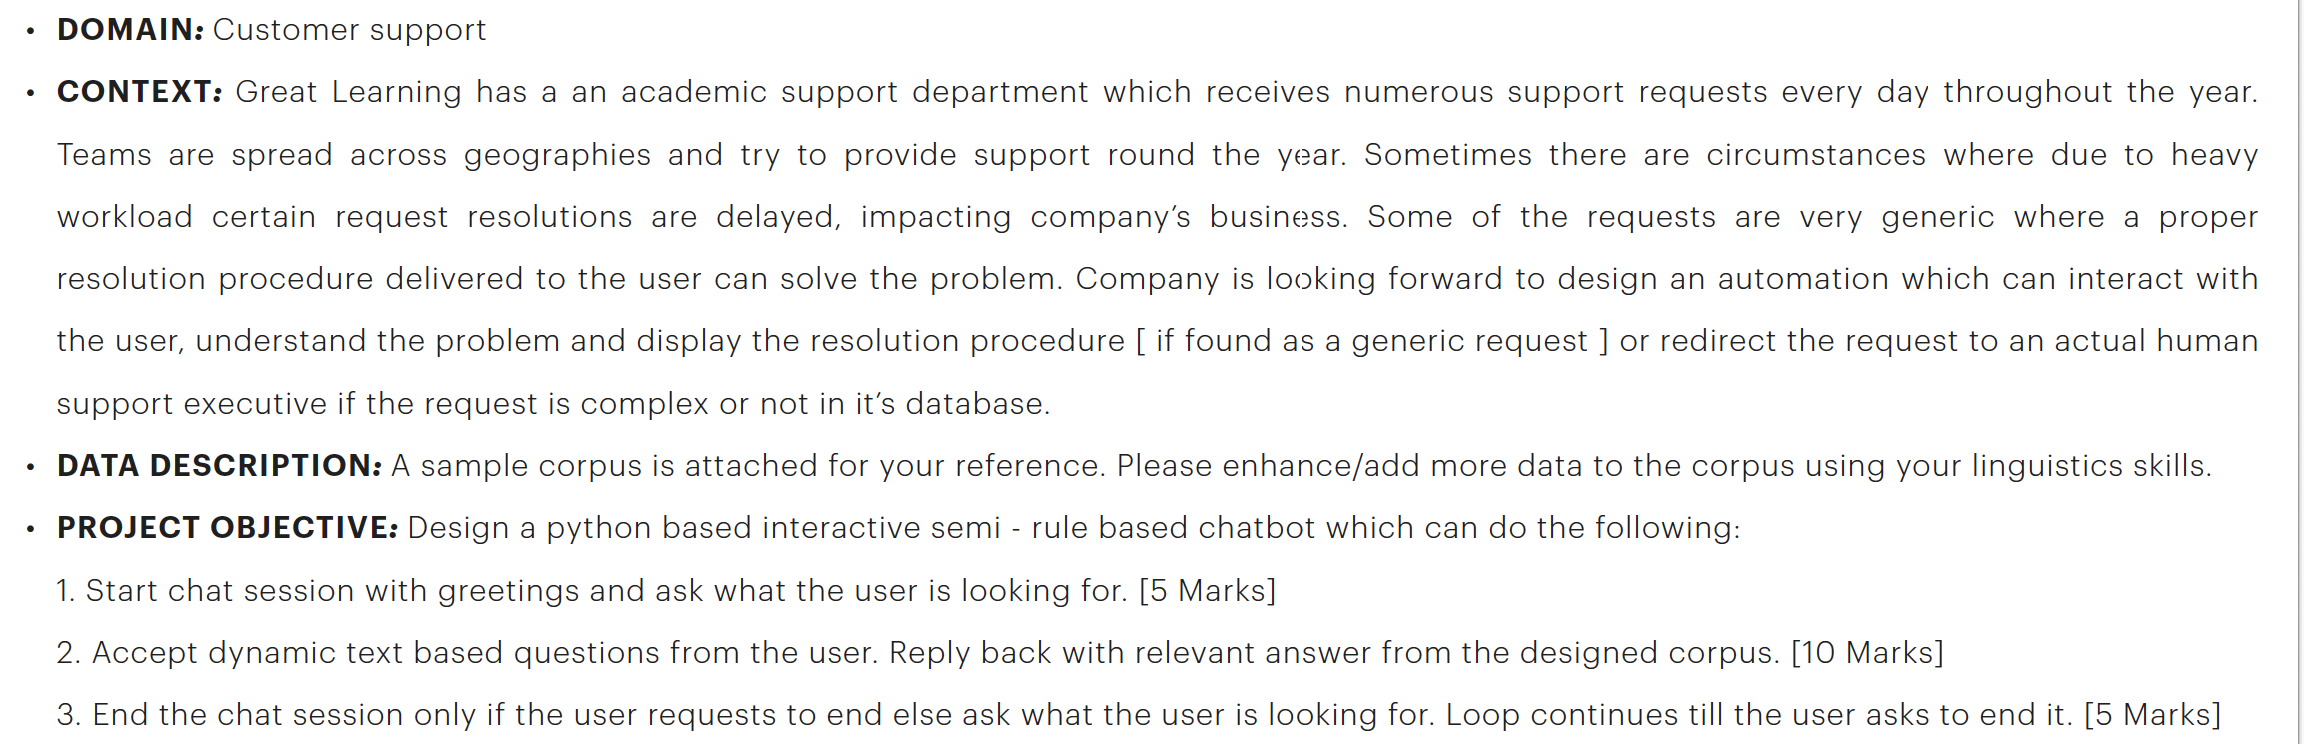

In [2]:
# initialize the empty list and read the provided content file
words = []
classes = []
documents = []
data_file = open("GL Bot.json").read()
intents = json.loads(data_file)

In [3]:
# Convert the intents file to a dataframe
testDf = pd.DataFrame(intents['intents']).drop(columns=['context_set'], axis=1)

In [4]:
testDf

,tag,patterns,responses
0,Intro,"[hi, how are you, is anyone there, hello, what...",[Hello! how can i help you ?]
1,Exit,"[thank you, thanks, cya, see you, later, see y...","[I hope I was able to assist you, Good Bye]"
2,Olympus,"[olympus, explain me how olympus works, I am n...",[Link: Olympus wiki]
3,SL,"[i am not able to understand svm, explain me h...",[Link: Machine Learning wiki ]
4,NN,"[what is deep learning, unable to understand d...",[Link: Neural Nets wiki]
5,Bot,"[what is your name, who are you, name please, ...",[I am your virtual learning assistant]
6,Profane,"[what the hell, bloody stupid bot, do you thin...",[Please use respectful words]
7,Ticket,"[my problem is not solved, you did not help me...",[Tarnsferring the request to your PM]


In [5]:
#create a dictionary to store responses for given tags
responseDict = dict(zip(testDf['tag'], [response[0] for response in testDf['responses']]))

In [6]:
#explode dataframe to have one pattern per row
intentsDf = testDf.explode('patterns').reset_index(drop=True)

In [7]:
intentsDf

,tag,patterns,responses
0,Intro,hi,[Hello! how can i help you ?]
1,Intro,how are you,[Hello! how can i help you ?]
2,Intro,is anyone there,[Hello! how can i help you ?]
3,Intro,hello,[Hello! how can i help you ?]
4,Intro,whats up,[Hello! how can i help you ?]
...,...,...,...
123,Ticket,not good solution,[Tarnsferring the request to your PM]
124,Ticket,no help,[Tarnsferring the request to your PM]
125,Ticket,wasted my time,[Tarnsferring the request to your PM]
126,Ticket,useless bot,[Tarnsferring the request to your PM]


In [8]:
#Adding new linguistic based patterns to intents 
extraTagsDf = pd.DataFrame({
    'tag' : ['Intro', 'Intro', 'Intro', 'Profane', 'Profane', 'Ticket', 'Ticket','Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit'],
    'patterns' : ['Good morning',  'Good afternoon',  'Good evening', 'idiot', 'thats stupid' ,'need grade information', 'need help on support queries', 'Good night', 'bye', 'Good bye', 'Take care', 'exit','quit']
})

In [9]:
#create responses column based on the new patterns added 
extraTagsDf['responses'] = [[responseDict[tag]] for tag in extraTagsDf['tag']]

In [10]:
#final intents dataframe to be used for downstream processing
intentsDf = pd.concat([intentsDf, extraTagsDf])

## Preprocessing Steps

In [11]:
#List of all the stop words
use_stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "how", "are", "you", "your", "yourself", "myself"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

use_stopwords = list(set(use_stopwords) - set(customlist))   

In [12]:
# functions to preprocess the textual data
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

intentsDf['patterns'] = intentsDf['patterns'].apply(lambda x: strip_html(x))


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in use_stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return " ".join(words)

intentsDf['patterns_tok'] = intentsDf.apply(lambda row: normalize(row['patterns'].split(" ")), axis=1)

In [13]:
#create dataframe  post processing of data
intentsDf = intentsDf.sample(frac=1).reset_index(drop=True)
intentsDf.head()

,tag,patterns,responses,patterns_tok
0,Profane,you are a joke,[Please use respectful words],you be joke
1,NN,what is an epoch,[Link: Neural Nets wiki],epoch
2,NN,unable to understand neural nets,[Link: Neural Nets wiki],unable understand neural net
3,Olympus,how to use olympus,[Link: Olympus wiki],how use olympus
4,NN,artificial intelligence,[Link: Neural Nets wiki],artificial intelligence


In [14]:
# Vectorization (Convert text data to numbers).
vector_word = CountVectorizer(max_features=1000)               
data_features = vector_word.fit_transform(intentsDf['patterns_tok'])
data_features = data_features.toarray()

In [15]:
#one-hot-encoding of the class
labels=pd.get_dummies(intentsDf['tag']).astype(int)

In [16]:
#convert the class labels to a list
classLabels = list(labels.columns)

In [17]:
#check the class labels
classLabels

['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']

In [18]:
# create train and test lists. X - patterns, Y - intents
X_train_chat = data_features
y_train_chat = labels

In [19]:
#clear the backend session
backend.clear_session()
tf.random.set_seed(42)

In [20]:
#  function to create and compile neural network model
def create_model_chat(lr): 
    model_chat = Sequential()
    model_chat.add(InputLayer(input_shape=X_train_chat.shape[1]))
    model_chat.add(Dense(128, activation='relu'))
    model_chat.add(Dropout(0.2))
    model_chat.add(Dense(y_train_chat.shape[1], activation="softmax"))
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr)
    model_chat.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer=optimizer) 
    return model_chat

In [21]:
#create a keras classifier instance
keras_estimator_chat = KerasClassifier(build_fn=create_model_chat, verbose=1)

# define the hyperparameters and pass it through GridSearchCV 
param_grid_chat = {
    'batch_size':[8,16, 32, 64, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 5
model_chat_grid = GridSearchCV(estimator=keras_estimator_chat,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_grid=param_grid_chat,n_jobs=-1)

In [22]:
# Fit the model
history_chat=model_chat_grid.fit(X_train_chat, y_train_chat, validation_split=0.2, epochs=30, verbose=1)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


2023-08-04 22:47:33.424820: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-04 22:47:33.509445: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-04 22:47:33.523676: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30


2023-08-04 22:47:33.552332: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-04 22:47:33.558027: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-04 22:47:33.571064: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-04 22:47:33.584793: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-04 22:47:33.638748: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


12/12 [==============================] - 0s 12ms/step - loss: 1.9282 - accuracy: 0.2778 - val_loss: 1.7814 - val_accuracy: 0.3478
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.9711 - accuracy: 0.3034 - val_loss: 1.7139 - val_accuracy: 0.4348
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.9566 - accuracy: 0.2778 - val_loss: 1.6527 - val_accuracy: 0.3478
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.9534 - accuracy: 0.2333 - val_loss: 1.8564 - val_accuracy: 0.3043
Epoch 2/30
12/12 [==============================] - 0s 3ms/step - loss: 1.2441 - accuracy: 0.7444 - val_loss: 1.5368 - val_accuracy: 0.4348
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 2.9440 - accuracy: 0.2022 - val_loss: 1.7550 - val_accuracy: 0.3913
Epoch 2/30
12/12 [==============================] - 0s 4ms/step - loss: 1.3373 - accuracy: 0.7191 - val_loss: 1.5322 - val_accuracy: 0.5217
Epoch 3/30
12/12 [========

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
12/12 [==============================] - 0s 12ms/step - loss: 3.2314 - accuracy: 0.2333 - val_loss: 1.7912 - val_accuracy: 0.3043
Epoch 2/30
12/12 [==============================] - 0s 8ms/step - loss: 2.0661 - accuracy: 0.1333 - val_loss: 1.9506 - val_accuracy: 0.3913
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 2.0932 - accuracy: 0.0899 - val_loss: 2.0519 - val_accuracy: 0.1739
Epoch 2/30
12/12 [==============================] - 0s 8ms/step - loss: 2.0678 - accuracy: 0.1222 - val_loss: 2.0785 - val_accuracy: 0.0870
Epoch 2/30
12/12 [==============================] - 0s 4ms/step - loss: 0.7462 - accuracy: 0.8111 - val_loss: 2.0260 - val_accuracy: 0.4348
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 2.6224 - accuracy: 0.2556 - val_loss: 1.6635 - val_accuracy: 0.3478
Epoch 2/30
12/12 [==============================] - 0s 3ms/step - loss: 2.0015 - accuracy: 0.2222 - va

12/12 [==============================] - 0s 3ms/step - loss: 6.1574e-05 - accuracy: 1.0000 - val_loss: 7.8167 - val_accuracy: 0.4783
Epoch 29/30
12/12 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.9775 - val_loss: 1.3841 - val_accuracy: 0.5217
Epoch 29/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.9444 - val_loss: 1.5494 - val_accuracy: 0.3913
Epoch 27/30
12/12 [==============================] - 0s 4ms/step - loss: 0.5985 - accuracy: 0.9444 - val_loss: 1.4743 - val_accuracy: 0.3913
Epoch 28/30
12/12 [==============================] - 0s 3ms/step - loss: 0.0093 - accuracy: 0.9889 - val_loss: 7.9669 - val_accuracy: 0.4783
Epoch 30/30
12/12 [==============================] - 0s 3ms/step - loss: 0.6022 - accuracy: 0.9663 - val_loss: 1.3726 - val_accuracy: 0.5217
Epoch 30/30
12/12 [==============================] - 0s 3ms/step - loss: 0.5610 - accuracy: 0.9556 - val_loss: 1.4702 - val_accuracy: 0.3913
Epoch 29/30
4/4 [====

12/12 [==============================] - 0s 4ms/step - loss: 0.5151 - accuracy: 0.9667 - val_loss: 1.5028 - val_accuracy: 0.3913
Epoch 1/30
4/4 [==============================] - 0s 2ms/step - loss: 1.3355 - accuracy: 0.5000
Epoch 1/30
6/6 [==============================] - 0s 26ms/step - loss: 2.0062 - accuracy: 0.2556 - val_loss: 1.6829 - val_accuracy: 0.4348
Epoch 2/30
6/6 [==============================] - 0s 9ms/step - loss: 1.3950 - accuracy: 0.6556 - val_loss: 1.4400 - val_accuracy: 0.6522
Epoch 3/30
6/6 [==============================] - 0s 22ms/step - loss: 1.9498 - accuracy: 0.2444 - val_loss: 1.7697 - val_accuracy: 0.4783
Epoch 2/30
6/6 [==============================] - 0s 6ms/step - loss: 0.9184 - accuracy: 0.8889 - val_loss: 1.2758 - val_accuracy: 0.6522
Epoch 4/30
6/6 [==============================] - 0s 6ms/step - loss: 1.3812 - accuracy: 0.7000 - val_loss: 1.5947 - val_accuracy: 0.5217
Epoch 3/30
6/6 [==============================] - 0s 7ms/step - loss: 0.6117 - accu

Epoch 1/30
1/6 [====>.........................] - ETA: 1s - loss: 2.0916 - accuracy: 0.0625e+00

6/6 [==============================] - 0s 25ms/step - loss: 3.6427 - accuracy: 0.2889 - val_loss: 1.9804 - val_accuracy: 0.2609
Epoch 2/30
6/6 [==============================] - 0s 27ms/step - loss: 2.0701 - accuracy: 0.1573 - val_loss: 2.0456 - val_accuracy: 0.1739
Epoch 2/30
6/6 [==============================] - 0s 20ms/step - loss: 2.0593 - accuracy: 0.1556 - val_loss: 2.0683 - val_accuracy: 0.0870
Epoch 2/30
6/6 [==============================] - 0s 22ms/step - loss: 2.0514 - accuracy: 0.1556 - val_loss: 2.0207 - val_accuracy: 0.1739
Epoch 2/30
6/6 [==============================] - 0s 24ms/step - loss: 2.0580 - accuracy: 0.2000 - val_loss: 2.0419 - val_accuracy: 0.3478
Epoch 2/30
6/6 [==============================] - 0s 7ms/step - loss: 2.0037 - accuracy: 0.2247 - val_loss: 2.0179 - val_accuracy: 0.1739
Epoch 3/30
3/3 [==============================] - 0s 49ms/step - loss: 1.9841 - accuracy: 0.3146 - val_loss: 1.8133 - val_accuracy: 0.3913
Epoch 2/30
Epoch 3/30
6/6 [============

Epoch 26/30
6/6 [==============================] - 0s 8ms/step - loss: 0.8561 - accuracy: 0.9333 - val_loss: 1.5231 - val_accuracy: 0.5217
Epoch 30/30
Epoch 1/30
2/2 [==============================] - 0s 4ms/step - loss: 1.4573 - accuracy: 0.3571
Epoch 1/30
3/3 [==============================] - 0s 23ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.7070 - val_accuracy: 0.5217
Epoch 27/30
3/3 [==============================] - 0s 15ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.8293 - val_accuracy: 0.5652
Epoch 28/30
2/2 [==============================] - 0s 3ms/step - loss: 1.5083 - accuracy: 0.5000
Epoch 1/30
3/3 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.8281 - val_accuracy: 0.5652
Epoch 29/30
3/3 [==============================] - 0s 10ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.9274 - val_accuracy: 0.5217
Epoch 30/30
1/3 [=========>....................] - ETA: 0s - loss: 2.1552 - accuracy: 0.0312

3/3 [==============================] - 0s 58ms/step - loss: 1.9911 - accuracy: 0.2000 - val_loss: 1.8190 - val_accuracy: 0.4348
Epoch 2/30
3/3 [==============================] - 0s 55ms/step - loss: 2.0471 - accuracy: 0.1889 - val_loss: 1.7505 - val_accuracy: 0.3043
Epoch 2/30
3/3 [==============================] - 0s 12ms/step - loss: 1.4633 - accuracy: 0.6556 - val_loss: 1.7010 - val_accuracy: 0.4348
Epoch 3/30
3/3 [==============================] - 0s 12ms/step - loss: 1.5158 - accuracy: 0.6000 - val_loss: 1.6154 - val_accuracy: 0.4348
Epoch 3/30
3/3 [==============================] - 0s 13ms/step - loss: 1.0980 - accuracy: 0.8111 - val_loss: 1.4849 - val_accuracy: 0.4783
Epoch 4/30
3/3 [==============================] - 0s 11ms/step - loss: 1.1276 - accuracy: 0.8556 - val_loss: 1.5674 - val_accuracy: 0.4348
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 0.8262 - accuracy: 0.9000 - val_loss: 1.3893 - val_accuracy: 0.5217
Epoch 5/30
3/3 [======================

3/3 [==============================] - 0s 12ms/step - loss: 4.2861e-04 - accuracy: 1.0000 - val_loss: 2.3984 - val_accuracy: 0.4348
Epoch 21/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 2.5008 - val_accuracy: 0.4348
Epoch 22/30
1/3 [=========>....................] - ETA: 0s - loss: 4.7397e-04 - accuracy: 1.0000Epoch 1/30
Epoch 1/30
Epoch 1/30
3/3 [==============================] - 0s 23ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 2.1392 - val_accuracy: 0.5217
Epoch 23/30
3/3 [==============================] - 0s 15ms/step - loss: 0.0327 - accuracy: 0.9889 - val_loss: 3.3261 - val_accuracy: 0.4348
Epoch 24/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 2.3170 - val_accuracy: 0.5217
Epoch 25/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 3.1832 - val_accuracy: 0.4348
Epoch 26/30
3/3 [==============================] - 

3/3 [==============================] - 0s 13ms/step - loss: 1.7958 - accuracy: 0.6444 - val_loss: 1.9130 - val_accuracy: 0.4348
Epoch 9/30
3/3 [==============================] - 0s 12ms/step - loss: 1.7194 - accuracy: 0.7333 - val_loss: 1.9420 - val_accuracy: 0.4783
Epoch 3/30
Epoch 13/30
3/3 [==============================] - 0s 8ms/step - loss: 1.6165 - accuracy: 0.8315 - val_loss: 1.7742 - val_accuracy: 0.5652
Epoch 16/30
3/3 [==============================] - 0s 11ms/step - loss: 1.6549 - accuracy: 0.7222 - val_loss: 1.7099 - val_accuracy: 0.6522
Epoch 14/30
3/3 [==============================] - 0s 9ms/step - loss: 1.7487 - accuracy: 0.6889 - val_loss: 1.8992 - val_accuracy: 0.3913
Epoch 11/30
3/3 [==============================] - 0s 10ms/step - loss: 1.7086 - accuracy: 0.7556 - val_loss: 1.9249 - val_accuracy: 0.4783
Epoch 14/30
3/3 [==============================] - 0s 17ms/step - loss: 1.7652 - accuracy: 0.6778 - val_loss: 1.9738 - val_accuracy: 0.2609
Epoch 10/30
3/3 [=======

1/1 [==============================] - 0s 22ms/step - loss: 1.6626 - accuracy: 0.5517
Epoch 1/30
2/2 [==============================] - 0s 16ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 1.5696 - val_accuracy: 0.5652
Epoch 26/30
2/2 [==============================] - 0s 45ms/step - loss: 0.0519 - accuracy: 1.0000 - val_loss: 1.1322 - val_accuracy: 0.5652
Epoch 17/30
2/2 [==============================] - 0s 19ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 1.6387 - val_accuracy: 0.5652
Epoch 27/30
2/2 [==============================] - 0s 17ms/step - loss: 0.0528 - accuracy: 1.0000 - val_loss: 1.2529 - val_accuracy: 0.5217
Epoch 18/30
2/2 [==============================] - 0s 22ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 1.6474 - val_accuracy: 0.5652
Epoch 28/30
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000Epoch 1/30
Epoch 1/30
2/2 [==============================] - 0s 30ms/step - loss: 0.0533 - accuracy: 1.0000 - val_loss: 1.1

2/2 [==============================] - 0s 20ms/step - loss: 0.0269 - accuracy: 1.0000 - val_loss: 1.2260 - val_accuracy: 0.5217
Epoch 24/30
2/2 [==============================] - 0s 20ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 1.2962 - val_accuracy: 0.5217
Epoch 25/30
2/2 [==============================] - 0s 19ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 1.4519 - val_accuracy: 0.5217
Epoch 26/30
2/2 [==============================] - 0s 20ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 1.4033 - val_accuracy: 0.5217
Epoch 27/30
2/2 [==============================] - 0s 20ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 1.4108 - val_accuracy: 0.5217
Epoch 28/30
2/2 [==============================] - 0s 18ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 1.3814 - val_accuracy: 0.5217
Epoch 29/30
2/2 [==============================] - 0s 20ms/step - loss: 1.2266 - accuracy: 0.8000 - val_loss: 1.5967 - val_accuracy: 0.4348
Epoch 4/30
2/2 [================

Epoch 12/30
2/2 [==============================] - 0s 123ms/step - loss: 2.4891 - accuracy: 0.1000 - val_loss: 5.6672 - val_accuracy: 0.3043
Epoch 12/30
Epoch 2/30
2/2 [==============================] - 0s 23ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 1.7293 - val_accuracy: 0.4783
Epoch 10/30
2/2 [==============================] - 0s 18ms/step - loss: 0.1182 - accuracy: 1.0000 - val_loss: 1.4073 - val_accuracy: 0.4783
Epoch 11/30
Epoch 13/30
2/2 [==============================] - 0s 17ms/step - loss: 3.2303 - accuracy: 0.5667 - val_loss: 2.5831 - val_accuracy: 0.3043
Epoch 13/30
Epoch 3/30
2/2 [==============================] - 0s 19ms/step - loss: 0.0600 - accuracy: 0.9889 - val_loss: 2.0363 - val_accuracy: 0.4783
Epoch 8/30
Epoch 9/30
2/2 [==============================] - 0s 21ms/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 1.8844 - val_accuracy: 0.4783
Epoch 11/30
2/2 [==============================] - 0s 20ms/step - loss: 0.1060 - accuracy: 0.9889 - val_loss: 1.432

Epoch 1/30
2/2 [==============================] - 0s 20ms/step - loss: 7.9280e-04 - accuracy: 1.0000 - val_loss: 2.7228 - val_accuracy: 0.5652
Epoch 30/30
2/2 [==============================] - 0s 24ms/step - loss: 1.6653 - accuracy: 0.7753 - val_loss: 1.8316 - val_accuracy: 0.4783
Epoch 18/30
2/2 [==============================] - 0s 22ms/step - loss: 1.6566 - accuracy: 0.8090 - val_loss: 1.8156 - val_accuracy: 0.4783
Epoch 19/30
2/2 [==============================] - 0s 21ms/step - loss: 1.6336 - accuracy: 0.7753 - val_loss: 1.8093 - val_accuracy: 0.4783
Epoch 1/30
Epoch 20/30
2/2 [==============================] - 0s 29ms/step - loss: 1.6167 - accuracy: 0.7753 - val_loss: 1.7974 - val_accuracy: 0.4783
Epoch 21/30
2/2 [==============================] - 0s 20ms/step - loss: 1.5928 - accuracy: 0.7865 - val_loss: 1.7840 - val_accuracy: 0.4783
Epoch 22/30
2/2 [==============================] - 0s 23ms/step - loss: 1.5736 - accuracy: 0.8202 - val_loss: 1.7771 - val_accuracy: 0.4783
Epoch 

2/2 [==============================] - 0s 24ms/step - loss: 1.5428 - accuracy: 0.8539 - val_loss: 1.7649 - val_accuracy: 0.4348
Epoch 25/30
2/2 [==============================] - 0s 26ms/step - loss: 1.5079 - accuracy: 0.8876 - val_loss: 1.7589 - val_accuracy: 0.4783
Epoch 26/30
2/2 [==============================] - 0s 26ms/step - loss: 1.4928 - accuracy: 0.8764 - val_loss: 1.7502 - val_accuracy: 0.4783
Epoch 27/30
2/2 [==============================] - 0s 119ms/step - loss: 2.0835 - accuracy: 0.0778 - val_loss: 2.0463 - val_accuracy: 0.0435
Epoch 2/30
2/2 [==============================] - 0s 15ms/step - loss: 1.4697 - accuracy: 0.8989 - val_loss: 1.7414 - val_accuracy: 0.5217
Epoch 28/30
2/2 [==============================] - 0s 122ms/step - loss: 2.0811 - accuracy: 0.1111 - val_loss: 2.0065 - val_accuracy: 0.2174
Epoch 2/30
2/2 [==============================] - 0s 25ms/step - loss: 2.0388 - accuracy: 0.1333 - val_loss: 2.0305 - val_accuracy: 0.0435
Epoch 3/30
2/2 [================

1/1 [==============================] - 0s 347ms/step - loss: 2.0875 - accuracy: 0.1124 - val_loss: 1.8805 - val_accuracy: 0.3913
Epoch 2/30
2/2 [==============================] - 0s 19ms/step - loss: 1.9668 - accuracy: 0.4000 - val_loss: 2.0571 - val_accuracy: 0.1304
Epoch 5/30
2/2 [==============================] - 0s 22ms/step - loss: 1.8963 - accuracy: 0.4111 - val_loss: 1.9596 - val_accuracy: 0.3043
Epoch 8/30
2/2 [==============================] - 0s 26ms/step - loss: 1.8873 - accuracy: 0.5000 - val_loss: 1.9275 - val_accuracy: 0.3043
Epoch 7/30
2/2 [==============================] - 0s 21ms/step - loss: 1.9508 - accuracy: 0.4667 - val_loss: 2.0460 - val_accuracy: 0.2174
Epoch 3/30
Epoch 6/30
2/2 [==============================] - 0s 19ms/step - loss: 1.8815 - accuracy: 0.4667 - val_loss: 1.9488 - val_accuracy: 0.3043
Epoch 9/30
Epoch 1/30
1/1 [==============================] - 0s 337ms/step - loss: 2.0642 - accuracy: 0.1778 - val_loss: 1.8554 - val_accuracy: 0.4783
Epoch 2/30
2/2

1/1 [==============================] - 0s 34ms/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 1.1720 - val_accuracy: 0.5652
Epoch 26/30
1/1 [==============================] - 0s 29ms/step - loss: 0.0399 - accuracy: 1.0000 - val_loss: 1.4952 - val_accuracy: 0.4783
Epoch 22/30
1/1 [==============================] - 0s 20ms/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 1.1857 - val_accuracy: 0.5652
Epoch 27/30
1/1 [==============================] - 0s 25ms/step - loss: 0.0419 - accuracy: 1.0000 - val_loss: 1.5160 - val_accuracy: 0.4783
Epoch 23/30
1/1 [==============================] - 0s 19ms/step - loss: 0.0374 - accuracy: 1.0000 - val_loss: 1.5411 - val_accuracy: 0.4783
Epoch 24/30
1/1 [==============================] - 0s 25ms/step - loss: 0.0269 - accuracy: 1.0000 - val_loss: 1.2397 - val_accuracy: 0.5652
Epoch 29/30
1/1 [==============================] - 0s 29ms/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 1.5718 - val_accuracy: 0.4783
Epoch 25/30
1/1 [===============

1/1 [==============================] - 0s 30ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 1.6314 - val_accuracy: 0.4783
Epoch 29/30
Epoch 1/30
1/1 [==============================] - 0s 46ms/step - loss: 1.6828 - accuracy: 0.6556 - val_loss: 1.8296 - val_accuracy: 0.3478
Epoch 2/30
Epoch 3/30
1/1 [==============================] - 0s 52ms/step - loss: 0.0288 - accuracy: 1.0000 - val_loss: 1.7097 - val_accuracy: 0.4783
Epoch 30/30
1/1 [==============================] - 0s 28ms/step - loss: 1.3427 - accuracy: 0.8778 - val_loss: 1.7262 - val_accuracy: 0.3913
Epoch 4/30
Epoch 3/30
1/1 [==============================] - 0s 16ms/step - loss: 1.0295 - accuracy: 0.9111 - val_loss: 1.6334 - val_accuracy: 0.4783
Epoch 5/30
1/1 [==============================] - 0s 18ms/step - loss: 4.7075 - accuracy: 0.4607 - val_loss: 3.1670 - val_accuracy: 0.3478
Epoch 4/30
1/1 [==============================] - 0s 15ms/step - loss: 0.4279 - accuracy: 0.8652 - val_loss: 1.6718 - val_accuracy: 0.5217
Epo

1/1 [==============================] - 0s 30ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 2.5288 - val_accuracy: 0.5217
Epoch 7/30
1/1 [==============================] - 0s 18ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.3483 - val_accuracy: 0.6087
Epoch 17/30
1/1 [==============================] - 0s 36ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.1772 - val_accuracy: 0.4348
Epoch 30/30
1/1 [==============================] - 0s 24ms/step - loss: 1.7642 - accuracy: 0.7416 - val_loss: 1.8803 - val_accuracy: 0.5652
Epoch 18/30
1/1 [==============================] - 0s 12ms/step - loss: 1.8618 - accuracy: 0.5778 - val_loss: 1.9215 - val_accuracy: 0.4783
Epoch 9/30
1/1 [==============================] - 0s 26ms/step - loss: 1.7475 - accuracy: 0.7079 - val_loss: 1.8731 - val_accuracy: 0.5652
Epoch 19/30
1/1 [==============================] - 0s 14ms/step - loss: 1.7624 - accuracy: 0.5000
Epoch 10/30
1/1 [==============================] - 0s 16ms/step - loss: 1.74

1/1 [==============================] - 0s 9ms/step - loss: 1.5544 - accuracy: 0.9111 - val_loss: 1.8889 - val_accuracy: 0.3913
Epoch 27/30
1/1 [==============================] - 0s 9ms/step - loss: 1.5383 - accuracy: 0.9333 - val_loss: 1.8828 - val_accuracy: 0.3913
Epoch 28/30
1/1 [==============================] - 0s 11ms/step - loss: 1.5243 - accuracy: 0.9222 - val_loss: 1.8766 - val_accuracy: 0.3913
Epoch 29/30
1/1 [==============================] - 0s 10ms/step - loss: 1.5093 - accuracy: 0.9111 - val_loss: 1.8704 - val_accuracy: 0.3913
Epoch 30/30
1/1 [==============================] - 0s 9ms/step - loss: 1.8121 - accuracy: 0.4643
Epoch 1/30


2023-08-04 22:47:46.357421: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 404ms/step - loss: 2.0967 - accuracy: 0.1071 - val_loss: 1.8705 - val_accuracy: 0.3448
Epoch 2/30
1/1 [==============================] - 0s 11ms/step - loss: 1.6992 - accuracy: 0.7321 - val_loss: 1.7024 - val_accuracy: 0.4138
Epoch 3/30
1/1 [==============================] - 0s 11ms/step - loss: 1.3673 - accuracy: 0.8661 - val_loss: 1.5587 - val_accuracy: 0.4483
Epoch 4/30
1/1 [==============================] - 0s 12ms/step - loss: 1.0622 - accuracy: 0.9286 - val_loss: 1.4555 - val_accuracy: 0.4828
Epoch 5/30
1/1 [==============================] - 0s 12ms/step - loss: 0.7927 - accuracy: 0.9732 - val_loss: 1.3707 - val_accuracy: 0.4828
Epoch 6/30
1/1 [==============================] - 0s 13ms/step - loss: 0.6018 - accuracy: 0.9732 - val_loss: 1.3056 - val_accuracy: 0.5862
Epoch 7/30
1/1 [==============================] - 0s 12ms/step - loss: 0.4281 - accuracy: 0.9911 - val_loss: 1.2636 - val_accuracy: 0.5172
Epoch 8/30
1/1 [=====================

In [23]:
# Summarize results
print("Best: %f using %s" % (model_chat_grid.best_score_, model_chat_grid.best_params_))

Best: 0.560345 using {'batch_size': 128, 'lr': 0.01}


In [24]:
chat_estimator = create_model_chat(lr=model_chat_grid.best_params_['lr'])
chat_estimator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               18816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 19,848
Trainable params: 19,848
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Fit the model based on the best parameter
history_chat_opt=chat_estimator.fit(X_train_chat, y_train_chat,epochs=30, batch_size = model_chat_grid.best_params_['batch_size'],verbose=1,validation_split=0.2)

Epoch 1/30
1/1 [==============================] - 0s 205ms/step - loss: 2.0797 - accuracy: 0.1429 - val_loss: 1.8342 - val_accuracy: 0.4138
Epoch 2/30
1/1 [==============================] - 0s 12ms/step - loss: 1.6861 - accuracy: 0.6964 - val_loss: 1.6644 - val_accuracy: 0.5172
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 1.3511 - accuracy: 0.8839 - val_loss: 1.5585 - val_accuracy: 0.4828
Epoch 4/30
1/1 [==============================] - 0s 11ms/step - loss: 1.0303 - accuracy: 0.9554 - val_loss: 1.4604 - val_accuracy: 0.5172
Epoch 5/30
1/1 [==============================] - 0s 12ms/step - loss: 0.7828 - accuracy: 0.9821 - val_loss: 1.3821 - val_accuracy: 0.5172
Epoch 6/30
1/1 [==============================] - 0s 12ms/step - loss: 0.5664 - accuracy: 0.9911 - val_loss: 1.3339 - val_accuracy: 0.5862
Epoch 7/30
1/1 [==============================] - 0s 12ms/step - loss: 0.4285 - accuracy: 0.9911 - val_loss: 1.3020 - val_accuracy: 0.5862
Epoch 8/30
1/1 [==========

In [26]:
#saving order of feature names to generate feature vector from sentences
feature_names = vector_word.get_feature_names_out()

In [27]:
# Dictionary of numeric index and its corresponding class labels
classDict = dict(zip(range(0,len(y_train_chat.columns)),classLabels))

In [28]:
classDict

{0: 'Bot',
 1: 'Exit',
 2: 'Intro',
 3: 'NN',
 4: 'Olympus',
 5: 'Profane',
 6: 'SL',
 7: 'Ticket'}

In [29]:
# Dictionary of tags and its corresponding responses
responseDict = dict(zip(testDf['tag'], [response[0] for response in testDf['responses']]))

In [30]:
responseDict

{'Intro': 'Hello! how can i help you ?',
 'Exit': 'I hope I was able to assist you, Good Bye',
 'Olympus': 'Link: Olympus wiki',
 'SL': 'Link: Machine Learning wiki ',
 'NN': 'Link: Neural Nets wiki',
 'Bot': 'I am your virtual learning assistant',
 'Profane': 'Please use respectful words',
 'Ticket': 'Tarnsferring the request to your PM'}

### Function to convert query to its feature vector

In [31]:
def convertQueryToFeatureVector(query, featureNames):
  normalizedTokens = normalize(query.split(" ")).split(" ")
  #print(normalizedTokens)
  featureVector = np.zeros(len(featureNames))
  for token in normalizedTokens:
    tokenIndex = np.where(featureNames == token)
    if len(tokenIndex[0]) != 0:
      featureVector[int(tokenIndex[0])] = 1
  return featureVector.astype(int).reshape(1, len(featureNames))

### Function to get response from the query

In [32]:
def getResponseForQuery(query, feature_names, classDict, responseDict, modelBot):
  queryVector = convertQueryToFeatureVector(query, feature_names)
  if queryVector.sum() == 0:
    return responseDict['Ticket']
  else:
    queryPred = modelBot.predict(queryVector, verbose=0)
    return responseDict[classDict[np.argmax(queryPred)]]

In [33]:
tf.__version__

'2.12.0'

In [34]:
#Load the saved pickle file 
#loadedChatBot = loadModel("chatBot.pkl")
loadedChatBot = chat_estimator

### 1. Initialize bot

**Notes**
- Upon execution of the following cell bot greets the user and shows input text window
- For the sake of visualization, we used `stop` query input to exit the bot. 

In [35]:
botname = "GL-Bot"
flag = True
print(f"{botname}: My name is {botname}. How may I help you today?")
while(flag==True):
    query=input()
    if 'stop' in query:
      print(f"{botname}: bye")
      flag=False

GL-Bot: My name is GL-Bot. How may I help you today?


 Need help in ML
 stop


GL-Bot: bye


### 2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus. [10 Marks]

**Notes**
- Upon execution of the following cell bot greets the user and shows input text window
- User can keep asking question in the text window and bot replies accordingly
- The question and answer session goes on.
- For the sake of visualization, we used `stop` query input to exit the bot. 

In [170]:
botname = "GL-Bot"
greetings = ['good morning', 'good evening', 'good afternoon']
flag = True
print(f"{botname}: My name is {botname}. How may I help you today?")
while(flag==True):
    query=input()
    if query.lower() in greetings:
      response = "Wish you the same!"
      print(f"{botname}: {response}")
    elif 'stop' in query:
      print(f"{botname}: bye")
      flag=False
      break
    else:
      response = getResponseForQuery(query, feature_names, classDict, responseDict, loadedChatBot)
      print(f"{botname}: {response}")
    if(response != 'I hope I was able to assist you, Good Bye'):
        query=input()
        response = getResponseForQuery(query, feature_names, classDict, responseDict, loadedChatBot)
        if query.lower() in greetings:
          response = "Wish you the same!"
        print(f"{botname}: {response}")
        if 'stop' in query:
          print(f"{botname}: bye")
          flag=False
          break

GL-Bot: My name is GL-Bot. How may I help you today?


 Hi


GL-Bot: Hello! how can i help you ?


 Good morning


GL-Bot: Wish you the same!


 My name is Abhi


GL-Bot: I am your virtual learning assistant


 Need help on support


GL-Bot: Tarnsferring the request to your PM


 Why the olympus not working


GL-Bot: Link: Olympus wiki


 what is forward propagation


GL-Bot: Link: Neural Nets wiki


 i am not able to understand cross validation


GL-Bot: Link: Machine Learning wiki 


 Unable to understand NN


GL-Bot: Link: Neural Nets wiki


 What is supervised learning?


GL-Bot: Link: Machine Learning wiki 


 Lot of problem with olympus


GL-Bot: Link: Olympus wiki


 stop


GL-Bot: bye


### 3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it. [5 Marks]

**Notes**
- Upon execution of the following cell bot greets the user and shows input text window
- User can keep asking question in the text window and bot replies accordingly
- The question and answer session goes on.
- The chat session ends only when the user intents to ends the conversation.

In [171]:
botname = "GL-Bot"
flag = True
print(f"{botname}: My name is {botname}. How may I help you today?")
while(flag==True):
    query=input()
    response = getResponseForQuery(query, feature_names, classDict, responseDict, loadedChatBot)
    print(f"{botname}: {response}")
    if(response != 'I hope I was able to assist you, Good Bye'):
        query=input()
        response = getResponseForQuery(query, feature_names, classDict, responseDict, loadedChatBot)
        print(f"{botname}: {response}")
        if response == 'I hope I was able to assist you, Good Bye':
          flag=False
    else:
        flag=False

GL-Bot: My name is GL-Bot. How may I help you today?


 Hi Good morning


GL-Bot: Hello! how can i help you ?


 My name is Abhi


GL-Bot: I am your virtual learning assistant


 Need assistance on neural network


GL-Bot: Link: Neural Nets wiki


 what is an epoch


GL-Bot: Link: Neural Nets wiki


 solution was not good


GL-Bot: Tarnsferring the request to your PM


 what is boosting


GL-Bot: Link: Machine Learning wiki 


 stupid


GL-Bot: Please use respectful words


 thanks


GL-Bot: I hope I was able to assist you, Good Bye
